## Preprocessing

**Install packages . . .**

In [1]:
!pip install mne
!pip install braindecode
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 38.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 KB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 34.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.3/177.3 KB 3.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.1/155.1 KB 3.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 50.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.4 MB/s eta 0:00:00:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 47.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 3.9 MB/s eta 0:00:0000:0100:01


**Import packages . . .**

In [2]:
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
import logging

from braindecode.datasets import TUH, TUHAbnormal
from braindecode.preprocessing import (
    preprocess, Preprocessor, create_fixed_length_windows, scale as multiply)


plt.style.use('seaborn')
mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

**Loading the data . . .**

In [20]:
TUH_PATH = 'v2.0.0/' # specify the path to the TUH Abnormal dataset
N_JOBS = 8  # specify the number of jobs for loading and windowing
tuh = TUHAbnormal(
    path=TUH_PATH,
    recording_ids=None,
    target_name=None,
    preload=False,
    add_physician_reports=True,
    n_jobs=1 if TUH.__name__ == '_TUHMock' else N_JOBS,  # Mock dataset can't
    # be loaded in parallel
)

##### 1. Function for selecting a subset of 21 electrode positions following the international 10-20 placement
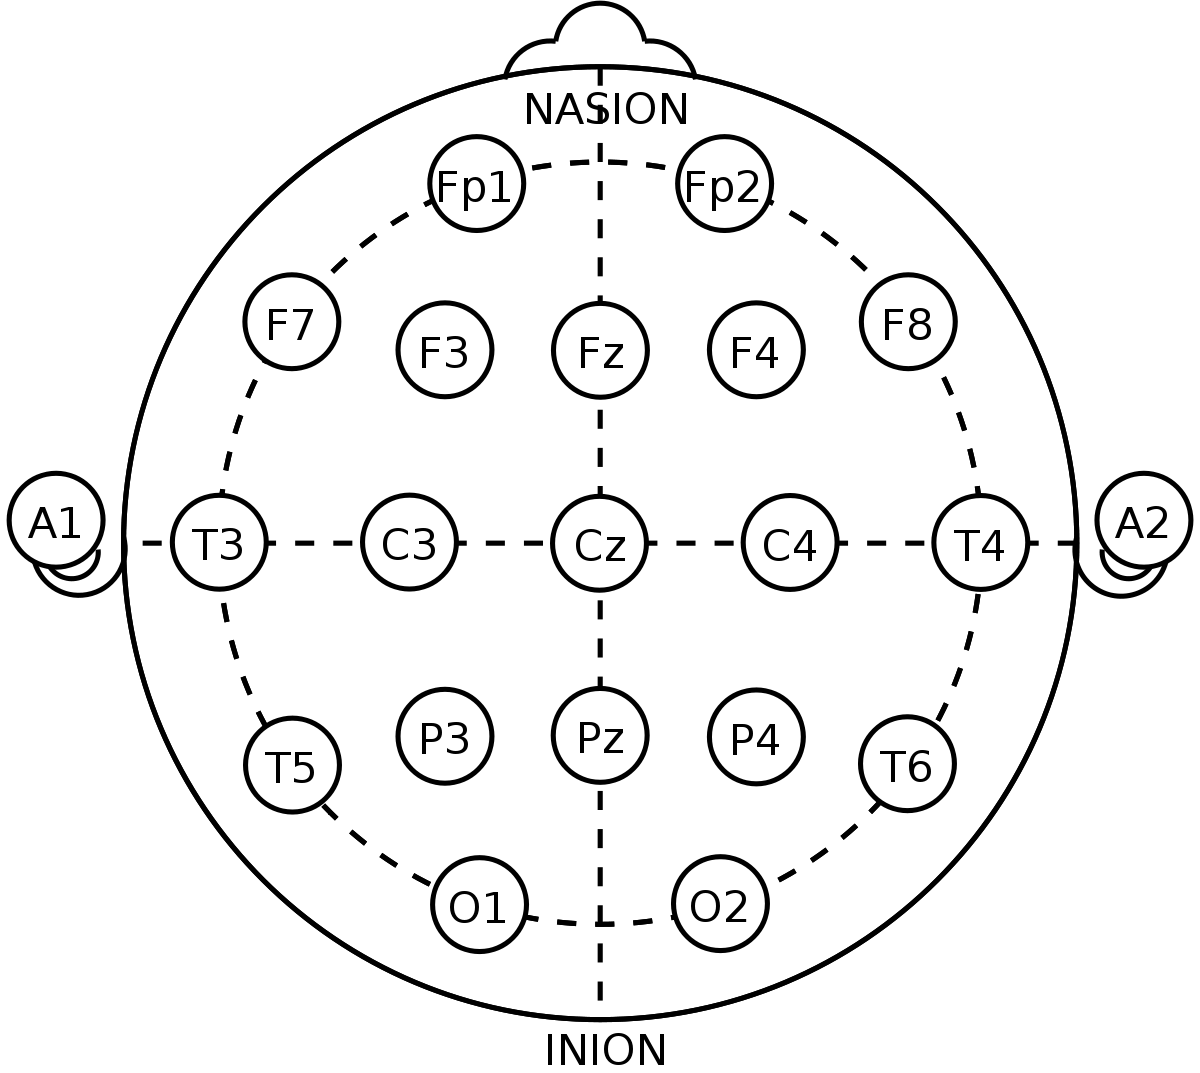

This function is not part of the preprocessing pipeline, hence needs to be executed separately.

In [21]:
# This function discards all the channels found in the recordings that have
# an incomplete configuration, and keep only those channels that we are interested in, i.e. the 21
# channels of the international 10-20-placement). The dataset is subdivided into
# recordings with 'le' and 'ar' reference which we will have to consider.

short_ch_names = sorted([
    'A1', 'A2',
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ'])
ar_ch_names = sorted([
    'EEG A1-REF', 'EEG A2-REF',
    'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
    'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
    'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
    'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'])
le_ch_names = sorted([
    'EEG A1-LE', 'EEG A2-LE',
    'EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE',
    'EEG C4-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE',
    'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE',
    'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE'])
assert len(short_ch_names) == len(ar_ch_names) == len(le_ch_names)
ar_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    ar_ch_names, short_ch_names)}
le_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    le_ch_names, short_ch_names)}
ch_mapping = {'ar': ar_ch_mapping, 'le': le_ch_mapping}


def select_by_channels(ds, ch_mapping):
    split_ids = []
    for i, d in enumerate(ds.datasets):
        ref = 'ar' if d.raw.ch_names[0].endswith('-REF') else 'le'
        # these are the channels we are looking for
        seta = set(ch_mapping[ref].keys())
        # these are the channels of the recoding
        setb = set(d.raw.ch_names)
        # if recording contains all channels we are looking for, include it
        if seta.issubset(setb):
            split_ids.append(i)
    return ds.split(split_ids)['0']

tuh = select_by_channels(tuh, ch_mapping)

##### 2-3. Function for cropping the first n seconds of every recording & use a maximum of m seconds

This function is part of the preprocessing pipeline.

In [33]:
# Based on: https://mne.tools/stable/generated/mne.io.Raw.html#mne.io.Raw.crop

def custom_crop(raw, tmin=0.0, tmax=None, include_tmax=True):
    # crop recordings to tmin – tmax. can be incomplete if recording
    # has lower duration than tmax
    # by default mne fails if tmax is bigger than duration
    tmax = min((raw.n_times - 1) / raw.info['sfreq'], tmax)
    raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)

Extra Custom function for renaming channels

In [ ]:
def custom_rename_channels(raw, mapping):
    # rename channels which are dependent on referencing:
    # le: EEG 01-LE, ar: EEG 01-REF
    # mne fails if the mapping contains channels as keys that are not present
    # in the raw
    reference = raw.ch_names[0].split('-')[-1].lower()
    assert reference in ['le', 'ref'], 'unexpected referencing'
    reference = 'le' if reference == 'le' else 'ar'
    raw.rename_channels(mapping[reference])

**Preprocessor Pipeline**

The **4th** and **5th** steps of the preprocessing, the **clipping at $\pm800\mu$v** and the **resampling** of the records don't have separate functions written, as we are using the mne package Raw class's functions.

In [23]:
# parameters to be defined for the preprocessing pipeline
tmin = 1 * 60
tmax = 21 * 60 # as the first minute of each recording is cropped, this is how we can keep 20 minutes of the recordings
sfreq = 100

preprocessors = [
    Preprocessor(custom_crop, tmin=tmin, tmax=tmax, include_tmax=True,
                 apply_on_array=False),
    Preprocessor('set_eeg_reference', ref_channels='average', ch_type='eeg'), # mne Raw class function
    Preprocessor(custom_rename_channels, mapping=ch_mapping, # rename channels to short channel names
                 apply_on_array=False), #
    Preprocessor('pick_channels', ch_names=short_ch_names, ordered=True), # mne Raw class function
    Preprocessor(multiply, factor=1e6, apply_on_array=True), # scaling signals to microvolt
    Preprocessor(np.clip, a_min=-800, a_max=800, apply_on_array=True), # clip outlier values to +/- 800 micro volts
    Preprocessor('resample', sfreq=sfreq), # mne Raw class function
]

In [24]:
import os.path

# Create output folder
current_directory = os.getcwd()
final_directory = os.path.join(current_directory, r'Output')
if not os.path.exists(final_directory):
   os.makedirs(final_directory)

N_JOBS = 8 # the number of CPUs to be used
OUT_PATH = 'Output/'  # please insert actual output directory here
tuh_preproc = preprocess(
    concat_ds=tuh,
    preprocessors=preprocessors,
    n_jobs=N_JOBS,
    save_dir=OUT_PATH
)

**A look into the preprocessed dataset**

Two newly added columns can also be found in the preprocessed dataset, *channels* and *length*, with the purpose of verifying the accuracy of the preprocessing.

In [27]:
# Adding channel positions for each recording
tuh_extended = tuh_preproc.description
channel_names = [] # np.empty(shape=(2993,))
for i in range(len(tuh_preproc.datasets)): 
    channel_names.append(tuh_preproc.datasets[i].raw.ch_names)
tuh_extended['channels'] = channel_names

# Adding the cropped length of each recording
length = [] # np.empty(shape=(2993,))
for i in range(len(tuh_preproc.datasets)): 
    length.append(tuh_preproc.datasets[i].raw.n_times / tuh_preproc.datasets[i].raw.info['sfreq'])
tuh_extended['length'] = length

tuh_extended.head(5)

path  year  month  day  \
0  v2.0.0/edf/eval/normal/01_tcp_ar/041/00004196/...  2009      9    3   
1  v2.0.0/edf/eval/normal/01_tcp_ar/058/00005864/...  2009      9    3   
2  v2.0.0/edf/train/normal/01_tcp_ar/009/00000929...  2009      9    4   
3  v2.0.0/edf/eval/normal/01_tcp_ar/058/00005851/...  2009      9    4   
4  v2.0.0/edf/train/normal/01_tcp_ar/059/00005909...  2009      9    9   

   subject  session  segment  age gender  \
0     4196        3        0   53      F   
1     5864        1        0   30      M   
2      929        3        2   39      F   
3     5851        1        1   65      F   
4     5909        2        0   32      M   

                                              report version  train  \
0  CLINICAL HISTORY:  Seizures.\nMEDICATIONS: Dil...  v2.0.0  False   
1  CLINICAL HISTORY: Schizophrenia, memory loss.\...  v2.0.0  False   
2  CLINICAL HISTORY:  Epilepsy, currently seizure...  v2.0.0   True   
3  CLINICAL HISTORY:  Sixty-five-year-old woman w...  v2.0.0  False   
4  CLINICAL HISTORY: 32 year old male with episod...  v2.0.0   True   

   pathological                                           channels  length  
0         False  [A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2,...  1200.0  
1         False  [A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2,...  1200.0  
2         False  [A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2,...  1127.0  
3         False  [A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2,...  1087.0  
4         False  [A1, A2, C3, C4, CZ, F3, F4, F7, F8, FP1, FP2,...  1200.0

In [8]:
window_size_samples = 1000
window_stride_samples = 1000
# generate compute windows here and store them to disk
tuh_windows = create_fixed_length_windows(
    tuh_preproc,
    window_size_samples=window_size_samples,
    window_stride_samples=window_stride_samples,
    drop_last_window=False,
    n_jobs=N_JOBS,
)

for x, y, ind in tuh_windows:
    break